### Respuestas pregunta 5

* ¿Cómo elegiste cuáles marcar? 

    * Apliqué un balance de clases a todo el dataset de entrenamiento proporcionado y luego se entrenó el modelo con el algoritmo Gradient Boosting con los parámetros que óptimos que nos entregó el algoritmo GridSearch durante el entrenamiento. Posteriormente, el modelo fué aplicado sobre el dataset de test, al que se le aplicaron exactamente los mismos procedimientos de limpieza y selección de variables que al data de entrenamiento.

* ¿De qué depende que predigas la existencia de mayor o menor cantidad de reggaetones?

    * En orden de importancia:
        * Del valor de qué tan bailable es el track (*danceability*)
        * Del tempo del track (*tempo_scale*)
        * De la estructura del mix música/palabras que hay en el track (*speechiness*)
        * De la intensidad, rapidez y lo ruidosa que sea el track (*energy*)
        * Si el track es mayoritariamente acústico o no (*acousticness*)
        * El nivel de positividad del track (*valence_scale*)    
       
    * Y si bien no podemos extraer de forma directa las reglas que nos entrega el modelo,a partir del EDA y análisis estadístico que hemos hecho podemos inferir que se espera que para predecir un reggaeton el track sea bailable (tengan alto *danceability*), poca predominancia de solo palabras por sobre música (*speechiness* muy bajo),intensidad media o alta (*energy*),sea medianamente o muy positivo (*valence_scale*) y con un tempo que nunca es bajo (*tempo_scale*).

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from time import time
# Set some Pandas options
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline') 
get_ipython().magic(u"config InlineBackend.figure_format='retina'")
import seaborn as sns
# Library's to apply balance technic's
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the necessary module's
from scipy.stats import chi2
from sklearn.preprocessing import MinMaxScaler,binarize
from sklearn.feature_selection import SelectKBest,mutual_info_classif,chi2,RFE,RFECV,SelectFromModel
from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,average_precision_score
from sklearn.metrics import roc_curve,classification_report,confusion_matrix,make_scorer
# Only for final delivery
import warnings
warnings.filterwarnings('ignore')

#### Plot functions

* Funciones personalizadas creadas para visualizar los datos

** References: ** 
*<https://stackoverflow.com/questions/9497524/displaying-3-histograms-on-1-axis-in-a-legible-way-matplotlib>*
*<>*

In [2]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')

### Caracterización general del dataset

* Hay 2230 registros de canciones de todo tipo y 70 de reggaeton. Las variables para ambos dataset son similares a excpeción de *time_signature* que solo está presente en las canciones de todo tipo.


* Las variables *key* y *mode* son enteros que representan categorías, mientras que *duration* es una variable que representa el tiempo en milisegundo. El resto de las variables corresponden a distintos score numéricos que representan características de los track como popularidad, qué tan apto es para el baile, qué tan vocal o instrumental es, etc.


* Podemos ver que la cantidad de NA's es 0 para los track de reggaeton y muy baja para los track de otro tipo, en donde ninguna variable tiene más de 8 valores NAs, correspondientes a un 0.36% de los datos. 


* **Dada la baja proporción de NAs y que estos corresponden al dataset que contiene la clase mayoritaria no se harán imputaciones y se trabajará solo con los datos completos.**

In [3]:
df_todotipo=pd.read_csv('data_todotipo.csv',encoding='utf-8',sep=',')
del df_todotipo['Unnamed: 0']
df_todotipo=df_todotipo.dropna(how='any',axis=0).copy()
df_reggaeton=pd.read_csv('data_reggaeton.csv',encoding='utf-8',sep=',')
del df_reggaeton['Unnamed: 0']

#### Union de los datasets

* Para analizar el resto de las variables vamos a trabajar con el dataset ya unido, de tal forma que podamos comparar la variable cuando es reggaeton y cuando no de forma más simple y rápida.


* Para ello definiremos una variable *reggaeton* como 1 cuando sea un track de reggaeton y con valor 0 en cualquier otro caso. Posteriormente, unificaremos los tipos de datos de ambos dataset y finalmente haremos la unión.

In [4]:
del df_todotipo['time_signature']
df_reggaeton['reggaeton']=1
df_todotipo['reggaeton']=0
df_reggaeton['popularity']=df_reggaeton.popularity.astype('float64')
df_reggaeton['duration']=df_reggaeton.duration.astype('float64')
df=pd.concat([df_reggaeton,df_todotipo]).copy()

* Nuestra primera tarea será hacer el encoding de las variables categóricas para que Python las entienda como tal

* La segunda, dejar todas las variables numéricas en una escala similar

** Referencias: **
*<http://pbpython.com/categorical-encoding.html>*

In [5]:
df.loc[:,"key_code"] = df.key.astype('category')
df.loc[:,"mode_code"] = df['mode'].astype('category')
del df['key']
del df['mode']
del df['id_new']
df.loc[:,"reggaeton"] = df.reggaeton.astype('category')
df.loc[:,'loudness_scale']=MinMaxScaler().fit_transform(df[['loudness']])
df.loc[:,'tempo_scale']=MinMaxScaler().fit_transform(df[['tempo']])
del df['loudness']
del df['tempo']

Información del dataset:
 las clases del target son: Counter({0: 2222, 1: 70})


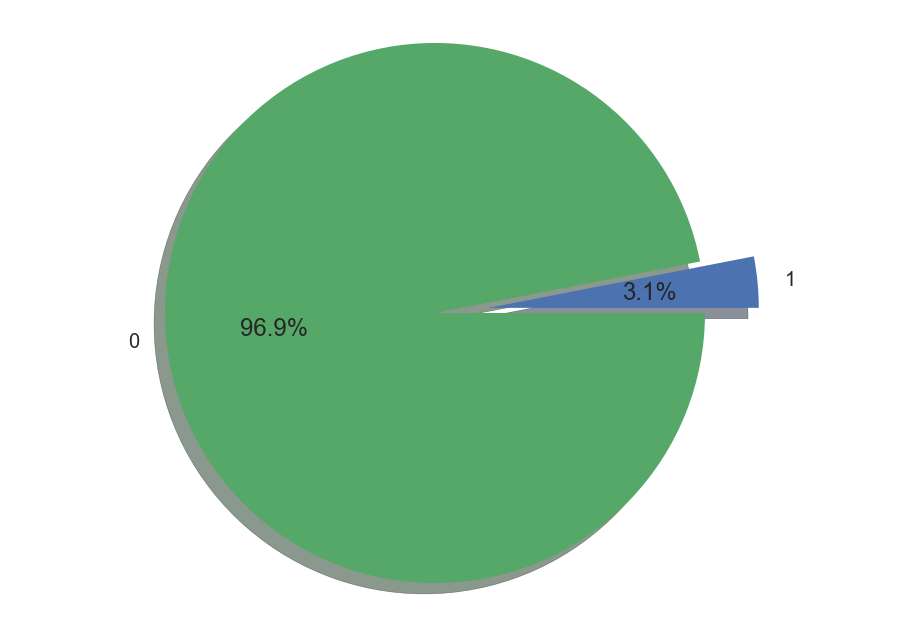

In [6]:
X=df.loc[:, df.columns != 'reggaeton']
y=df.reggaeton.ravel()
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y)))
plot_pie(y)

### Selección de variables

* Basados en el análisis estadístico, en los resultados de la métrica Mutual Information, el orden de importancia por coeficiente de SVClineal y por los resultados de aplicar Recursive feature engineer con los algoritmos Random Forest, Gradient Boosting y Regresión logística se decide eliminar 5 variables que eran candidatas:
    * *duration*
    * *liveness*
    * *loudness*
    * *key_code*
    * *instrumentalness*

In [7]:
del X['key_code']
del X['duration']
del X['popularity']
del X['mode_code']
del X['instrumentalness']
del X['loudness_scale']
del X['liveness']

### Entrenamiento y predicción

* Se aplicará el algoritmo Gradient Boosting con los datos de entrenamiento balanceados con el algoritmo Smote y los parámetros optimizados para el GB obtenidos en las entregas anteriores para entrenar


* Es importante notar que se utiliza un mínimo de 105 y no 75 porque corresponde al 3% del 80% del total de datos que se usarán para predecir, que es a lo que correspondían los 75 datos durante el modelamiento.


* Se usará un umbral de probabilidad predicha de ser reggaeton del 85% para que la canción sea clasificada como reggaeton

Información del dataset aplicando el algoritmo Smote:
 y: Counter({1: 2222, 0: 2222})


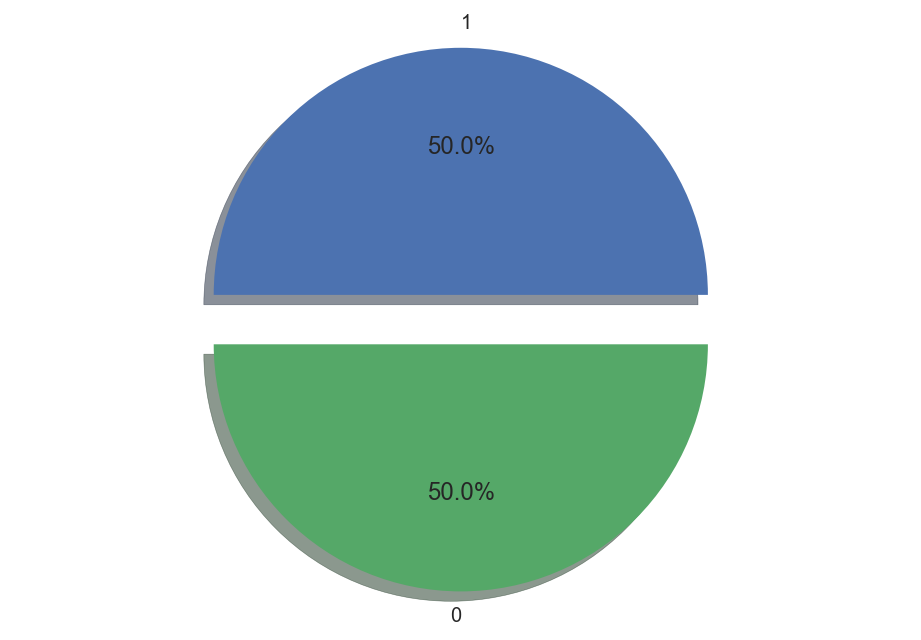

In [8]:
sm = SMOTE(random_state=0,n_jobs=-1)
X_res, y_res = sm.fit_sample(X, y)
print('Información del dataset aplicando el algoritmo Smote:'
      '\n y: {}'.format(Counter(y_res)))
plot_pie(y_res)

In [9]:
classifier_GB=GradientBoostingClassifier(
    random_state=0,subsample=0.8,n_estimators=300,presort=True,warm_start=True,
    max_features='auto', min_samples_split=106,min_samples_leaf=177)

In [10]:
model = classifier_GB.fit(X_res, y_res)

### Creación del dataset de test para generar las predicciones

* Al dataset de test se le debe aplicar exactamente el mismo procedimiento de limpieza que se aplicó a los datos de entrenamiento


* Posteriormente, se generan las predicciones utilizando el modelo entrenado previamente que está contenido en la variable *model*

In [11]:
df_test=pd.read_csv('data_test.csv',encoding='utf-8',sep=',')
del df_test['Unnamed: 0']
del df_test['time_signature']
df_test.loc[:,"key_code"] = df_test.key.astype('category')
df_test.loc[:,"mode_code"] = df_test['mode'].astype('category')
del df_test['key']
del df_test['mode']
del df_test['id_new']
df_test['popularity']=df_test.popularity.astype('float64')
df_test['duration']=df_test.duration.astype('float64')
df_test.head()

,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,key_code,mode_code
0,60.0,0.607,0.875,-4.434,0.0605,0.00114,0.007650,0.4670,0.4570,131.058,264520.0,0,1
1,69.0,0.757,0.868,-9.326,0.0620,0.41100,0.002210,0.3550,0.8150,138.923,199200.0,9,1
2,88.0,0.791,0.866,-4.236,0.0497,0.24800,0.000005,0.0696,0.7100,96.011,217080.0,6,1
3,70.0,0.589,0.484,-6.622,0.0266,0.48900,0.000000,0.1130,0.0927,120.258,269973.0,7,1
4,61.0,0.617,0.771,-5.586,0.1120,0.03840,0.000003,0.1620,0.5530,180.002,267747.0,10,0


In [12]:
df_test.loc[:,'loudness_scale']=MinMaxScaler().fit_transform(df_test[['loudness']])
df_test.loc[:,'tempo_scale']=MinMaxScaler().fit_transform(df_test[['tempo']])
del df_test['loudness']
del df_test['tempo']
df_test.head()

,popularity,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,duration,key_code,mode_code,loudness_scale,tempo_scale
0,60.0,0.607,0.875,0.0605,0.00114,0.007650,0.4670,0.4570,264520.0,0,1,0.941348,0.522230
1,69.0,0.757,0.868,0.0620,0.41100,0.002210,0.3550,0.8150,199200.0,9,1,0.746027,0.578321
2,88.0,0.791,0.866,0.0497,0.24800,0.000005,0.0696,0.7100,217080.0,6,1,0.949253,0.272283
3,70.0,0.589,0.484,0.0266,0.48900,0.000000,0.1130,0.0927,269973.0,7,1,0.853989,0.445207
4,61.0,0.617,0.771,0.1120,0.03840,0.000003,0.1620,0.5530,267747.0,10,0,0.895353,0.871286


In [13]:
X_test=df_test.loc[:, df_test.columns]
del X_test['key_code']
del X_test['duration']
del X_test['popularity']
del X_test['mode_code']
del X_test['instrumentalness']
del X_test['loudness_scale']
del X_test['liveness']

In [14]:
probs_prediction=model.predict_proba(X_test)

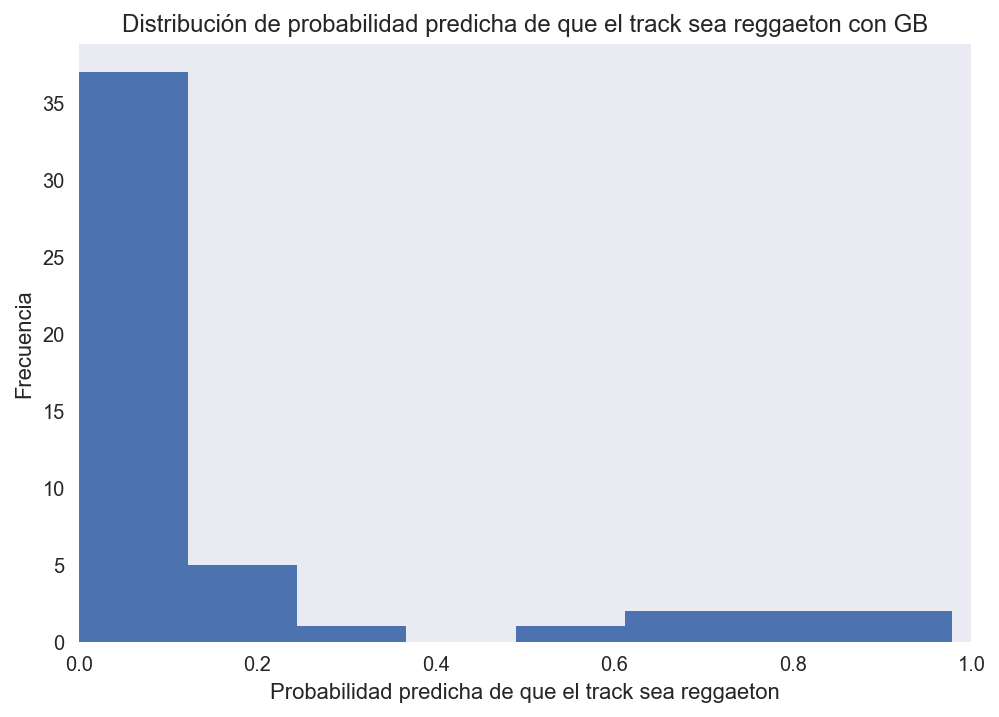

In [15]:
plt.hist(probs_prediction[:,1], bins=8)
plt.xlim(0, 1)
plt.title('Distribución de probabilidad predicha de que el track sea reggaeton con GB')
plt.xlabel('Probabilidad predicha de que el track sea reggaeton')
plt.ylabel('Frecuencia')
plt.grid(False);

In [16]:
preds=binarize([probs_prediction[:,1]],0.81)[0]

In [17]:
X_test['probabilidad_reggaeton']=probs_prediction[:,1]
X_test['marca_reggaeton']=preds

### Check en base al análisis estadístico

* Utilizamos las reglas que podemos extraer del análisis estadístico para comprobar si nuestras predicciones son un subconjunto de los posibles candidatos

In [18]:
df_test[(df_test.energy>=0.5) & (df_test.danceability>=0.5) & (df_test.instrumentalness<=0.1) & 
        (df_test.speechiness<=0.35) & (df_test.valence>=0.3) & (df_test.acousticness<=0.6)]

,popularity,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,duration,key_code,mode_code,loudness_scale,tempo_scale
0,60.0,0.607,0.875,0.0605,0.001140,0.007650,0.4670,0.457,264520.0,0,1,0.941348,0.522230
1,69.0,0.757,0.868,0.0620,0.411000,0.002210,0.3550,0.815,199200.0,9,1,0.746027,0.578321
2,88.0,0.791,0.866,0.0497,0.248000,0.000005,0.0696,0.710,217080.0,6,1,0.949253,0.272283
4,61.0,0.617,0.771,0.1120,0.038400,0.000003,0.1620,0.553,267747.0,10,0,0.895353,0.871286
5,75.0,0.502,0.972,0.0793,0.000068,0.000702,0.0627,0.729,197280.0,10,0,0.960273,0.571874
6,60.0,0.828,0.642,0.0821,0.306000,0.000714,0.1030,0.545,217966.0,1,1,0.822966,0.286368
7,71.0,0.770,0.790,0.0814,0.139000,0.000000,0.0829,0.872,195453.0,10,0,0.900663,0.257727
9,76.0,0.613,0.873,0.0449,0.003970,0.001110,0.3670,0.392,234813.0,7,0,0.863811,0.514606
10,78.0,0.766,0.519,0.0366,0.098000,0.000000,0.0855,0.612,267720.0,9,0,0.824723,0.514485
12,67.0,0.580,0.929,0.0388,0.062900,0.000223,0.2300,0.884,156198.0,4,0,0.924778,0.265037


In [20]:
X_test[X_test.marca_reggaeton==1].sort_values(by='probabilidad_reggaeton')

,danceability,energy,speechiness,acousticness,valence,tempo_scale,probabilidad_reggaeton,marca_reggaeton
6,0.828,0.642,0.0821,0.3060,0.545,0.286368,0.847705,1.0
13,0.725,0.842,0.0786,0.0859,0.750,0.300796,0.847815,1.0
46,0.637,0.700,0.1570,0.0213,0.807,0.897445,0.933980,1.0
37,0.743,0.656,0.1380,0.0578,0.802,0.814596,0.978709,1.0


In [21]:
X_test[X_test.probabilidad_reggaeton>=0.5].sort_values(by='probabilidad_reggaeton')

,danceability,energy,speechiness,acousticness,valence,tempo_scale,probabilidad_reggaeton,marca_reggaeton
16,0.868,0.764,0.1670,0.1190,0.397,0.279294,0.607952,0.0
7,0.770,0.790,0.0814,0.1390,0.872,0.257727,0.664275,0.0
28,0.746,0.922,0.2360,0.2460,0.638,0.207741,0.730765,0.0
6,0.828,0.642,0.0821,0.3060,0.545,0.286368,0.847705,1.0
13,0.725,0.842,0.0786,0.0859,0.750,0.300796,0.847815,1.0
46,0.637,0.700,0.1570,0.0213,0.807,0.897445,0.933980,1.0
37,0.743,0.656,0.1380,0.0578,0.802,0.814596,0.978709,1.0


### Creación del csv con las predicciones

* Guardamos el dataset con las predicciones y las variables sobre las cuales se aplico el modelo para predecir

In [22]:
X_test.to_csv('predicciones.csv',sep=',',header=True,encoding='utf-8',index=False)